In [1]:
import numpy as np
from mpmath import mp
from nested_lookup import nested_delete

In [2]:
mp.dps = 50  # Computation precision is 50 digits

In [77]:
def neighGraphAlg(z,maxDepth):
    """
    finds the edges in the neighbor graph for
    the parameter z.

    :param z: the parameter to check
    :type z: complex number
    :param maxDepth: maximum depth
    :type maxDepth: int
    :returns: the edges of the graph
    :rtype: dict
    """
    prec = 1e-14
    #initialize the dictionary of vertices in the graph
    vertices = {
        'id':0.,
        'h1':mp.mpc(-2./param),
        'h2':mp.mpc(2./param)
    }
    #initialize the dictionary of new vertices at the current stage
    newVertices = {
        'h1':mp.mpc(-2./param),
        'h2':mp.mpc(2./param)
    }
    #initialize the dictionary of edges between the vertices
    edges = {
        'id':{'h1':{'label':'+ -','weight':0.75},
              'h2':{'label':'- +','weight':0.25}}
    }
    
    
    depth = 0
    neighborIndex = 2; #the label of the last vertex created
    
    criticalRad = mp.mpf(2./(1-np.abs(param))) #the escape radius
    
    while len(newVertices) and depth<maxDepth:
        newChildren = {}
        verticesWithNoChild = {}
        
        #boolean values to check the existence of children of a vertex
        noChildPM = False
        noChildStar = False
        noChildMP = False
        
        # ----------------------------- for each vertex in newVertices --------------------------------------------
        for keyNb,valNb in newVertices.items():
            #compute the possible new neighbors
            phiStar = mp.mpc(1/param*(valNb)) # corresponds to fpm^(-1) g fpm
            phiPM = mp.mpc(1/param*(valNb-2)) # corresponds to fp^(-1) g fm
            phiMP = mp.mpc(1/param*(valNb+2)) # corresponds to fm^(-1) g fp
            
            #check if the computed neighbors exist already in the list of vertices
            matchStar = [key for key, value in vertices.items() if np.abs(value-phiStar) <= prec]#if value==phiStar] #
            matchPM = [key for key, value in vertices.items() if np.abs(value-phiPM) <= prec]#if value==phiPM] #
            matchMP = [key for key, value in vertices.items() if np.abs(value-phiMP) <= prec]#if value==phiMP] #
            
            
            if len(matchStar)==0: # phiStar is POSSIBLY a new vertex
                if mp.mpf(np.abs(phiStar))<=criticalRad or mp.mpf(np.abs(np.abs(phiStar)-criticalRad))<=prec:
                    noChildStar = False # phiStar IS a child vertex
                    neighborIndex+=1
                    
                    newChildren.update({f"h{neighborIndex}": phiStar})
                    vertices.update({f"h{neighborIndex}": phiStar})
                    
                    #if the current vertex has already some connections
                    #update with a new one
                    #otherwise create a new one
                    if keyNb in edges: 
                        edges[keyNb].update({f"h{neighborIndex}":{'label':' * ', 'weight': 0.5}})                        
                    else:
                        edges.update({keyNb:{f"h{neighborIndex}":{'label':' * ', 'weight': 0.5}}})
                else: # phiStar is NOT a VALID neighbor 
                    noChildStar = True
                    
            else: # phiStar ALREADY EXISTS
                noChildStar = False 
                if keyNb in edges:
                    edges[keyNb].update({matchStar[0]:{'label':' * ', 'weight': 0.5}})
                else:
                    edges.update({keyNb:{matchStar[0]:{'label':' * ', 'weight': 0.5}}})
                
            if len(matchPM)==0: # phiPM is POSSIBLY a new vertex
                if mp.mpf(np.abs(phiPM))<=criticalRad or mp.mpf(np.abs(np.abs(phiPM)-criticalRad))<=prec:
                    noChildPM = False # phiPM IS a child vertex
                    neighborIndex += 1
                                        
                    newChildren.update({f"h{neighborIndex}": phiPM})
                    vertices.update({f"h{neighborIndex}": phiPM})
                    
                    #if the current vertex has already some connections
                    #update with a new one
                    #otherwise create a new one
                    if keyNb in edges:
                        edges[keyNb].update({f"h{neighborIndex}":{'label':'+ -', 'weight': 0.75}})
                    else:
                        edges.update({keyNb:{f"h{neighborIndex}":{'label':'+ -', 'weight': 0.75}}})
                else: # phiPM is NOT a VALID neighbor 
                    noChildPM = True
            
            else: # phiPM ALREADY EXISTS
                noChildStar = False
                if keyNb in edges:
                    edges[keyNb].update({matchPM[0]:{'label':'+ -', 'weight': 0.75}})
                else:
                    edges.update({keyNb:{matchPM[0]:{'label':'+ -', 'weight': 0.75}}})
            
            if len(matchMP)==0: # phiMP is POSSIBLY a new vertex
                if mp.mpf(np.abs(phiMP))<=criticalRad or mp.mpf(np.abs(np.abs(phiMP)-criticalRad))<=prec:
                    noChildMP = False # phiMP IS a child vertex
                    neighborIndex += 1
                    
                    newChildren.update({f"h{neighborIndex}": phiMP})
                    vertices.update({f"h{neighborIndex}": phiMP})
                    
                    #if the current vertex has already some connections
                    #update with a new one
                    #otherwise create a new one
                    if keyNb in edges:
                        edges[keyNb].update({f"h{neighborIndex}":{'label':'- +', 'weight': 0.25}})
                    else:
                        edges.update({keyNb:{f"h{neighborIndex}":{'label':'- +', 'weight': 0.25}}})
                else: # phiMP is NOT a VALID neighbor 
                    noChildMP = True
            
            else: # phiMP ALREADY EXISTS
                noChildStar = False
                if keyNb in edges:
                    edges[keyNb].update({matchMP[0]:{'label':'- +', 'weight': 0.25}})
                else:
                    edges.update({keyNb:{matchMP[0]:{'label':'- +', 'weight': 0.25}}})
                    
            #in the case that all the computed neighbors are  not valid
            #save the current neighbor
            if noChildStar and noChildPM and noChildMP:
                verticesWithNoChild.update({keyNb: valNb})
        #------------------------------------- end for loop ----------------------------------------------------
        
        #if there are neighbors without children
        #remove them from the list of vertices
        #and get rid of any edge connected to them 
        if len(verticesWithNoChild)!=0:
            vertices = {k:v for (k,v) in vertices.items() if k not in verticesWithNoChild }
            for key in verticesWithNoChild:
                edges = nested_delete(edges, key)
        
        #update the list of new vertices with the newly found vertices
        newVertices = newChildren
        depth += 1
        
    
    return edges


# Examples

## NOTE:
 make sure to erase vertices with out degree equal to 0., i.e. those nodes that have no children.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

In [79]:

neighborgraph = neighGraphAlg(mp.mpc(1/np.sqrt(2)),13)

# print(' /// BEFORE ///  ')
# print(neighborgraph)

for k,v in neighborgraph.items():
    if len(v)==0:
        neighborgraph = nested_delete(neighborgraph,k)
# print(' /// AFTER ///  ')
# print(neighborgraph)

newG =nx.DiGraph(neighborgraph)
deadnodes = [node for node,degree in dict(newG.out_degree()).items() if degree == 0]

newG.remove_nodes_from(deadnodes)
nx.write_gexf(newG, "testSqrt.gexf")
# newFG =nx.DiGraph(neighborgraph)
# print(newG.out_degree())
# deadnodes = [node for node,degree in dict(newFG.out_degree()).items() if degree == 0]

# newFG.remove_nodes_from(deadnodes)
options = {
#     'width':1.0,
#     'node_color':'white',
    'alpha':0.572,
#     'edge_color':'white',
    'node_size':700,
    "connectionstyle":'arc3, rad = 0.1',
    'with_labels':True,
    'font_size':'small',
    'font_color':'black',
    'font_weight':'bold'
}

# pos = nx.circular_layout(newG)
# pos = nx.circular_layout(newFG)
# nx.draw(newG,pos,**options)
# nx.draw(newFG,pos,**options)


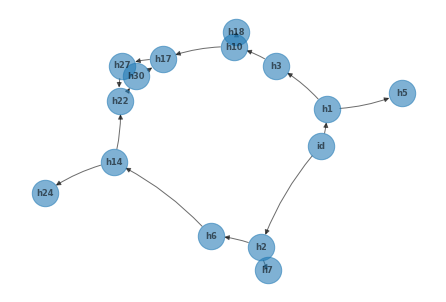

In [103]:

neighborgraph = neighGraphAlg(0.05277415108645189611947896053229129518349675421389 + 
 0.68814740940655613016868820363694147172435466851358j,13)

for k,v in neighborgraph.items():
    if len(v)==0:
        neighborgraph = nested_delete(neighborgraph,k)

newG =nx.DiGraph(neighborgraph)
deadnodes = [node for node,degree in dict(newG.out_degree()).items() if degree == 0]

newG.remove_nodes_from(deadnodes)
options = {
#     'width':1.0,
#     'node_color':'white',
    'alpha':0.572,
#     'edge_color':'white',
    'node_size':700,
    "connectionstyle":'arc3, rad = 0.1',
    'with_labels':True,
    'font_size':'small',
    'font_color':'black',
    'font_weight':'bold'
}

pos = nx.spectral_layout(newG)
nx.draw(newG,pos,**options)

In [89]:
(1+np.sqrt(7)*1j)/4

(0.25+0.6614378277661477j)

In [ ]:
# from nested_lookup import nested_delete
# import json

newdict={'a':{'aa':{'aaa':0},'jj':{'jjj':7}},
         'b':{'bb':{'bbb':1,'bbbb':2}},
         'c':{'cc':{'ccc':3}},
         'd':{'dd':{'ddd':1,'dddd':2}},
         'e':{'aa':{'aaa':0},'gg':{'ggg':2}},
         'aa':{}
        }

{k:v for k,v in newdict.items() if bool(v)}
# ict =  {'a':{'aa':{'aaa':0}},'c':{'cc':{'ccc':3}} }
# val = [key for i in list(ict.values()) for key in i.keys()]
# print(val) 
# print( ict.keys() )
# newDict = newdict
# for k in ict:
#     newDict=nested_delete(newDict,k)
# print(newDict)
# print('')
# print(newdict)
# {k:v for (k,v) in newdict.items() if isinstance(v, dict) }

In [ ]:
pip install nested_lookup

In [108]:
mp.mpc(2./mp.mpc(1/np.sqrt(2)))

mpc(real='2.8284271247461903483467210294237738115367269382644596', imag='0.0')

In [110]:
mp.mpc(2)/(mp.mpc(1)/mp.mpc(np.sqrt(2)))

mpc(real='2.828427124746190290949243717477656900882720947265625', imag='0.0')

In [ ]:
2.8284271247461900976033774484193961571393437507539